# ResBlock MLP Network with Hadamard Layer and I2E Shortcut


## 1. Pretreatment


Import Configuration.

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import yaml

import torch
import torch.nn as nn
from torchinfo import summary

with open("./config/SC_ResBlock.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

Import data.

In [2]:
InputData = sp.io.loadmat(config["DATA_LOADER"]["INPUT_DATA_PATH"])["KinematicsData"]
OutputData = sp.io.loadmat(config["DATA_LOADER"]["OUTPUT_DATA_PATH"])["DynRegVecData"]

Import `NN_utils` and `Visualization`.

In [3]:
import sys

sys.path.append("../utils")
from Blocks import *
from NN_utils import *
from Visualization import *

SETUP_SEED(42)
torch.set_default_dtype(torch.float64)

Size of input and output data.

In [4]:
InputData.shape, OutputData.shape

((50000, 28), (50000, 413))

Create **Training**, **Validation** and **Test** datasets.

In [5]:
InputData = torch.from_numpy(InputData)
OutputData = torch.from_numpy(OutputData)
TrainingLoader, ValidationLoader, TestLoader = Split2Loaders(
    InputData, OutputData, config
)

## 2. Training


Define ResBlock with Dropout.

In [6]:
class ResLinear_Dropout(nn.Module):
    def __init__(
        self, input_size, output_size, hidden_size=None, dropout=None, bias=True
    ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = output_size if hidden_size is None else hidden_size
        self.output_size = output_size
        self.Linear_1 = nn.Linear(input_size, hidden_size, bias=bias)
        self.Linear_2 = nn.Linear(hidden_size, output_size, bias=bias)
        self.Shortcut = nn.Linear(input_size, output_size, bias=False)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
        else:
            self.register_parameter("dropout", None)

    def forward(self, x):
        Out = self.Linear_1(x)
        if self.dropout is not None:
            Out = self.dropout(Out)
        return self.Linear_2(torch.relu(Out)) + self.Shortcut(x)

    def __repr__(self):
        return f"ResLinear(in_feature={self.input_size}, out_feature={self.output_size}, bias={self.Linear_1.bias is not None})"

Define MLP network structure.

In [7]:
class DynReg_MLP(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        embedding_size,
        ResBlock_size=None,
        ResBlock_hidden_size=None,
        sliding_pair=True,
        hadmard_bias=True,
        shortcut=True,
    ):
        if ResBlock_size is None or ResBlock_hidden_size is None:
            ResBlock_size = [512, 512]
            ResBlock_hidden_size = [256, 512, 512]
        super().__init__()
        # Degree of Freedom
        self.DoF = input_size // 4
        # Triangular Layer
        self.TrigLayer = Triangular(SlidingPair=sliding_pair)
        # Linear Layer List
        self.NN = nn.ModuleList()
        self.NNStruct = (
            [input_size + self.DoF * (sliding_pair + 1)]
            + ResBlock_size
            + [embedding_size]
        )
        for i in range(len(self.NNStruct) - 1):
            self.NN.append(
                ResLinear_Dropout(
                    input_size=self.NNStruct[i],
                    output_size=self.NNStruct[i + 1],
                    hidden_size=(
                        ResBlock_hidden_size[i]
                        if ResBlock_hidden_size[i] is not None
                        else None
                    ),
                    dropout=0.25,
                )
            )
            self.NN.append(nn.BatchNorm1d(num_features=self.NNStruct[i + 1]))
        self.Hadamard = HadamardProduct(embedding_size, bias=hadmard_bias)
        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)
        if shortcut:
            self.Shortcut = ShortcutMapping(input_size, embedding_size)
        else:
            self.register_parameter("Shortcut", None)

    def forward(self, x):
        Output = self.TrigLayer(x)
        for layer in self.NN:
            Output = layer(Output)
        if self.Shortcut is not None:
            Output = self.Hadamard(Output) + self.Shortcut(x)
        else:
            Output = self.Hadamard(Output)
        return self.LinearMapping(Output)

Define network.

In [8]:
Net = DynReg_MLP(
    input_size=config["NETWORK"]["INPUT_SIZE"],
    output_size=config["NETWORK"]["OUTPUT_SIZE"],
    embedding_size=config["NETWORK"]["EMBEDDING_SIZE"],
    ResBlock_size=config["NETWORK"]["RES_BLOCK_SIZE"],
    ResBlock_hidden_size=config["NETWORK"]["RES_BLOCK_HIDDEN_SIZE"],
    sliding_pair=True,
    hadmard_bias=True,
    shortcut=True,
)

Summary.

In [9]:
summary(
    Net,
    input_data=torch.zeros(1, InputData.shape[1]),
    device=GET_DEVICE(-1),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 28]         [1, 413]        --
├─Triangular: 1-1                        [1, 28]         [1, 42]         --
├─ModuleList: 1-2                        --              --              --
│    └─ResLinear_Dropout: 2-1            [1, 42]         [1, 256]        --
│    │    └─Linear: 3-1                  [1, 42]         [1, 128]        5,504
│    │    └─Dropout: 3-2                 [1, 128]        [1, 128]        --
│    │    └─Linear: 3-3                  [1, 128]        [1, 256]        33,024
│    │    └─Linear: 3-4                  [1, 42]         [1, 256]        10,752
│    └─BatchNorm1d: 2-2                  [1, 256]        [1, 256]        512
│    └─ResLinear_Dropout: 2-3            [1, 256]        [1, 256]        --
│    │    └─Linear: 3-5                  [1, 256]        [1, 256]        65,792
│    │    └─Dropout: 3-6                 [1, 256]        [1, 256]  

Define loss function.

In [10]:
def SparityLoss(SparityPromotingLayer, OutputFromNet, OutputFromData):
    sparity_loss = 0
    for layer in SparityPromotingLayer:
        for _, param in layer.named_parameters():
            sparity_loss += torch.abs(param).sum()

    return sparity_loss

Define optimizer.

In [11]:
optimizer = torch.optim.Adam(
    Net.parameters(),
    lr=config["TRAIN"]["LEARNING_RATE"],
    weight_decay=config["TRAIN"]["WEIGHT_DECAY"],
)

Training network.

In [12]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_TWO_LOSS(
    MODEL=Net,
    CONFIG=config,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: SparityLoss(
            [Net.Shortcut.NonZero, Net.LinearMapping],
            y1,
            y2,
        ),
    ],
    FREEZE_LAYER=[Net.Shortcut.NonZero, Net.LinearMapping],
)

PyTorch Version: 2.5.1
Weight initialized with Kaiming Initialization
Training on cuda:0
====================================Start training====================================


Epoch 30/30: 100%|██████████| 1250/1250 [00:09<00:00, 132.58batch/s, loss_1=3.74e+3, loss_2=3.74e+3]


====================================Finish training====================================



## 3. Visualization

Loss-Epoch Diagram

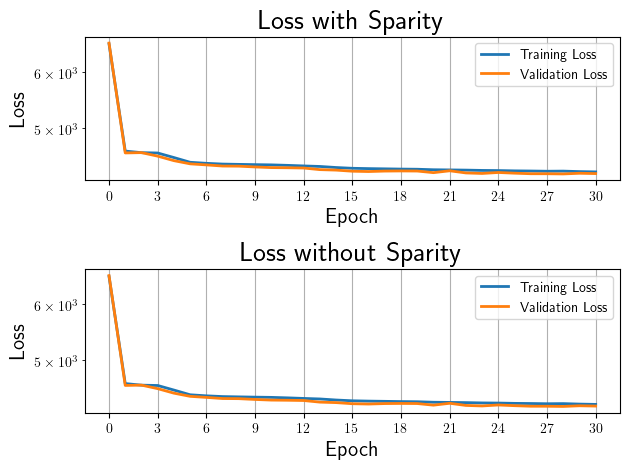

In [13]:
plt.rcParams["text.usetex"] = True
Loss_Epoch_Diagram = LOSS_EPOCH_DIAGRAM_TWO_LOSS(
    LOSS_HISTORY_TUPLE=(
        Loss_1_Training_History,
        Loss_1_Validation_History,
        Loss_2_Training_History,
        Loss_2_Validation_History,
    ),
    CONFIG=config,
    LAYER_NAME=["Shortcut", "LinearMapping"],
)

Final loss.

In [14]:
Loss_2_Validation_History[-1]

4307.618397681421